In [101]:
import os
import skimage.data
import skimage.transform
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
import time

Import necessary keras & Tensorflow library

In [102]:
# keras imports for building our neural network
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Activation, Lambda, Input, InputLayer, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, Precision, Recall
from tensorflow.keras import regularizers, optimizers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from keras.utils.data_utils import Sequence

making a note of time stamp to see total time taken to run these models

In [103]:
start_time = time.time()

In [104]:
directoryData = 'trafficsigns_dataset'

In [105]:
image_list = []

In [106]:
#iterating through all of the directories to find image paths & both sign type and shape type labels of images
for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True):
    shapeLabel = filepath.split("\\")[1]
    signLabel = filepath.split("\\")[2]
    image_list.append((filepath, signLabel, shapeLabel))

In [107]:
print("Total Images: {0}".format( len(image_list)))

Total Images: 3699


In [108]:
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'signLabel', 'shapeLabel'])

# Sign Type Prediction

## SVM on Sign Type

We will load all images and their respective labels to train on SVM dta

In [109]:
directoryData = 'trafficsigns_dataset'

# Get all subdirectories of dataset directory. Each represents a label.
directories_outer = [d for d in os.listdir(directoryData)
                   if os.path.isdir(os.path.join(directoryData, d))]

print(directories_outer)

Shape_labels = []
Sign_labels = []
images = []

for dirct in directories_outer:
    print(dirct)
    directory = os.path.join(directoryData, dirct)
    # Get all subdirectories of dataset directory. Each represents a label.
    directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
    print(directories)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    for d in directories:
        label_dir = os.path.join(directory, d)
        #print(label_dir)
        file_names = [os.path.join(label_dir, f)
                          for f in os.listdir(label_dir) if f.endswith(".png")]
        # For each label, load it's images and add them to the images list.
        # And add the label name (i.e. directory name) to the labels list.
        for f in file_names:
            # print(f)
            images.append(skimage.data.imread(f))
            Sign_labels.append(d)
            Shape_labels.append(dirct)
        
print("Unique Shape Labels: {0}\nUnique Sign Labels: {1}\nTotal Images: {2}".format(len(set(Shape_labels)), 
                                                                                    len(set(Sign_labels)), len(images)))

['diamond', 'hex', 'round', 'square', 'triangle']
diamond
['rightofway']
hex
['stop']
round
['bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection']
square
['continue', 'crossing', 'laneend', 'parking']
triangle
['giveway', 'warning']
Unique Shape Labels: 5
Unique Sign Labels: 16
Total Images: 3699


In [110]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

Sign_labels1 = le.fit_transform(Sign_labels)

labels_training = np.array(Sign_labels1)
images_training = np.array(images)
print("labels: ", labels_training.shape, "\nimages: ", images_training.shape)

# print("Shape before one-hot encoding: ", labels_training.shape)
# labels_training = keras.utils.to_categorical(labels_training, num_classes)
# print("Shape after one-hot encoding: ", labels_training.shape)

images_training = images_training.reshape(images_training.shape[0], 28, 28, 1)
images_training = images_training.astype('float32')
images_training /= 255


#from here we will be using the images. First we should flatten the images
n_samples = len(images_training)
data_images = images_training.reshape((n_samples, -1))

x_train, x_test, y_train, y_test = train_test_split(data_images, labels_training, test_size=0.2, 
                                                    stratify=labels_training,random_state=42)

x_train_svm, x_val_svm, y_train_svm, y_val_svm = train_test_split(x_train, y_train, test_size=0.2, 
                                                    stratify=y_train,random_state=42)

labels:  (3699,) 
images:  (3699, 28, 28)


In [111]:
# Create the parameter grid for approximate best values
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear','poly'], 'C': [1, 10, 100, 1000]}]

In [112]:
#Import svm model
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)

#Train the model using the training sets
svm_model.fit(x_train_svm, y_train_svm)


C:\Users\viran\Anaconda3\envs\Py3.6\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\viran\Anaconda3\envs\Py3.6\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\viran\Anaconda3\envs\Py3.6\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\viran\Anaconda3\envs\Py3.6\lib\site-p

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000],
                          'kernel': ['linear', 'poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [113]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(x_val_svm)
Y_pred_label = y_val_svm
# Y_pred_label = list(le.inverse_transform(y_val_svm))

Best score for training data: 0.959864807773553 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



Confusion matrix and classification report for validtion data.

In [114]:
print(confusion_matrix(Y_pred,Y_pred_label))
print("\n")
print(classification_report(Y_pred,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(x_train_svm , y_train_svm))
print("Validation  set score for SVM: %f" % final_model.score(x_val_svm  , y_val_svm ))

[[ 46   0   0   0   1   0   2   0   0   0   0   0   0   0   1   1]
 [  0  30   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  35   0   0   0   0   1   0   0   0   0   1   1   1]
 [  0   0   0   0  16   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   1   0   1  57   1   0   0   0   0   0   0   1   0]
 [  0   2   0   0   0   0   1  37   2   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  41   0   0   1   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0  43   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   1   0   0  15   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  47   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0  30   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  17 

Confusion matrix and classification report for test data.

In [115]:
Y_pred_test = final_model.predict(x_test)

print(confusion_matrix(Y_pred_test,y_test))
print("\n")
print(classification_report(Y_pred_test,y_test))

print("Testing set score for SVM: %f" % final_model.score(x_test , y_test))

[[ 56   0   0   0   0   0   1   3   0   0   0   0   0   0   0   0]
 [  0  39   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0  43   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0  22   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  24   0   1   0   2   0   0   0   2   2   0]
 [  0   0   0   0   0   0  73   0   0   0   0   0   0   0   0   1]
 [  1   0   0   0   0   1   0  44   1   0   0   0   0   0   0   2]
 [  0   0   0   1   0   0   0   0  53   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0  54   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0  20   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  62   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   9   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  37   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 

In [231]:
# from sklearn.metrics import plot_confusion_matrix

# disp = plot_confusion_matrix(final_model, x_test, y_test,
#                                  display_labels=final_model.classes_,
#                                  cmap=plt.cm.Blues,
#                                  normalize=True)
# disp.ax_.set_title('"Normalized confusion matrix"')

# print('"Normalized confusion matrix"')
# print(disp.confusion_matrix)

## CNN on Sign Type

Encoding a target label if we need it.

In [116]:
from sklearn import preprocessing

le_sign = preprocessing.LabelEncoder()

In [117]:
data['signLabel_transformed'] = le_sign.fit_transform(data['signLabel'])

In [118]:
#check unique sign labels of the data
set(data['signLabel'])

{'bicycle',
 'continue',
 'crossing',
 'giveway',
 'laneend',
 'limitedtraffic',
 'noentry',
 'noparking',
 'parking',
 'rightofway',
 'roundabout',
 'speed',
 'stop',
 'trafficdirective',
 'traveldirection',
 'warning'}

### Plot first image from each Sign type class

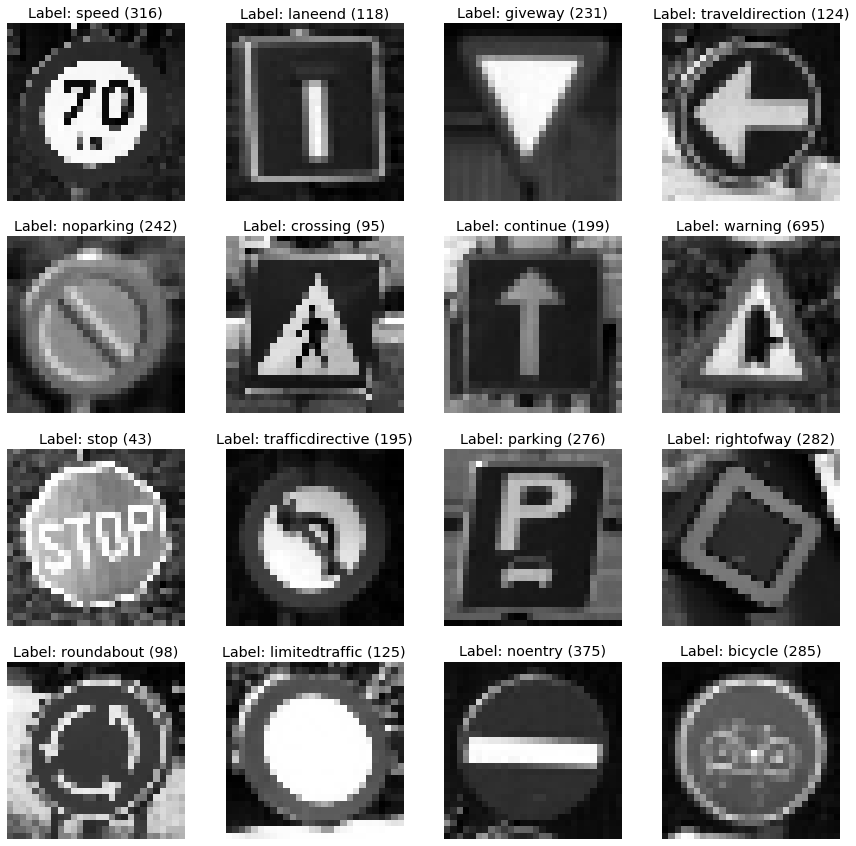

In [119]:
unique_labels = set(data['signLabel'])

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # pick the first image for each label
    image = skimage.data.imread(data.loc[list(data['signLabel']).index(label)][0])
    # Define 16 subplots 
    plt.subplot(4, 4, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label: {0} ({1})".format(label, list(data['signLabel']).count(label)))
    # Add 1 to the counter
    i += 1
    # plot this image 
    plt.imshow(image, cmap="gray")
    
# Show the plot
plt.show()

Plot bar chart of frequency count of each label in training 

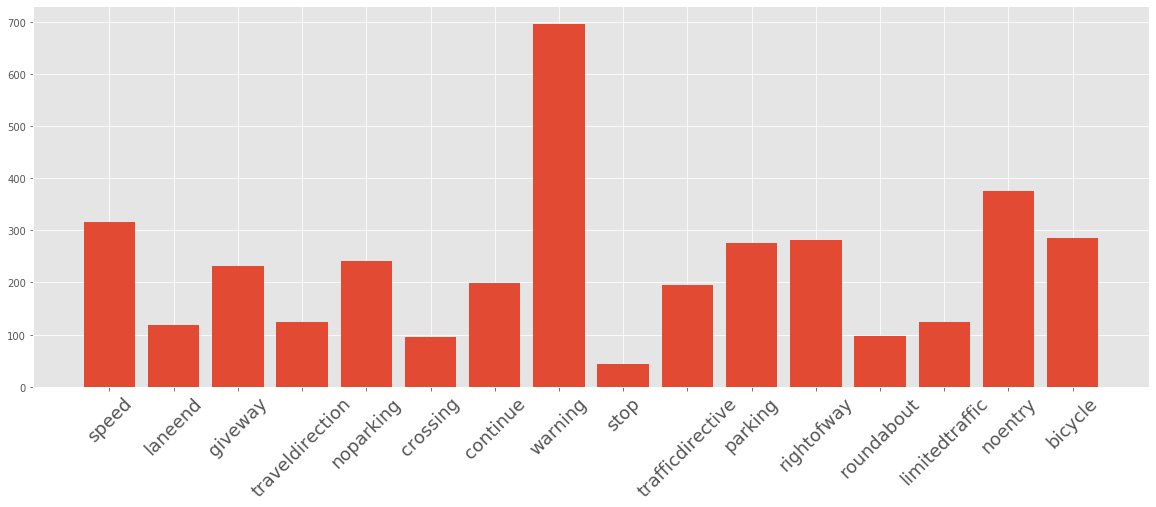

In [241]:
count = [list(data['signLabel']).count(label) for label in unique_labels]
unique_labels_bar = [label for label in unique_labels]

plt.figure(figsize=(20, 7))

plt.bar(np.arange(len(unique_labels_bar)), count)
plt.xticks(np.arange(len(unique_labels_bar)), unique_labels_bar, fontsize=18, rotation=45)

# Show the plot
plt.show()

**As can be seen, our target class labels are imblanced, so we can do augmentation/sampling to deal with this imbalance, but we will leverage the `class_weight` parameter of `fit_generator` to define imbalance. Aslo, only accuracy will not be a good measure for imbalanced class, so we will explore other metrics like precision, recall and f1-score.**

In [121]:
#split data into training and validation set
train_df_sign, validation_df_sign = train_test_split(data, test_size=0.3, 
                                                    stratify=data['signLabel'],random_state=42)

In [122]:
#split validation data into validation and test set
validation_df_sign, test_df_sign = train_test_split(validation_df_sign, test_size=0.3, 
                                                    stratify=validation_df_sign['signLabel'],random_state=42)

We will define dta generators to work on our model.

In [123]:
# define data generators for training & validation set
train_datagen_sign = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    data_format='channels_last')

val_datagen_sign = ImageDataGenerator(rescale=1./255,
                                     data_format='channels_last')

batch_size = 32

#training data generator
train_generator_sign = train_datagen_sign.flow_from_dataframe(
    dataframe=train_df_sign,
    directory='./',
    x_col="image_path",
    y_col="signLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator_sign.classes), 
            train_generator_sign.classes)


#validation data generator
validation_generator_sign = val_datagen_sign.flow_from_dataframe(
    dataframe=validation_df_sign,
    directory='./',
    x_col="image_path",
    y_col="signLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')


Found 2589 validated image filenames belonging to 16 classes.
Found 777 validated image filenames belonging to 16 classes.


**We will define a function to plot Loss/Accuracy graphs for our models to reduce redundancy**

In [124]:
def plot_accuracy(_model_hist, _epochs, _name):
    plt.style.use("ggplot")
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, _epochs), _model_hist.history["loss"], label="train_loss")
    plt.plot(np.arange(0, _epochs), _model_hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss of Belgian Traffic Sign Dataset\n Model: " + _name)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, _epochs), _model_hist.history["acc"], label="train_acc")
    plt.plot(np.arange(0, _epochs), _model_hist.history["val_acc"], label="val_acc")
    plt.title("Training Accuracy of Belgian Traffic Sign Dataset\n Model: " + _name)
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig("./figures/" + _name + ".png")

    return None

**We will define a function for training and evaluating(only by graph) our models as well**

In [125]:
def fit_and_evaluate_model(_model, _train_generator, _val_generator, _num_train_samples, _num_val_samples,
                        _batch_size, _epochs, class_weights, _model_name):

    _hist = _model.fit_generator(_train_generator,
                                 steps_per_epoch=_num_train_samples // _batch_size,
                                 class_weight=class_weights,
                                 epochs=_epochs,
                                 validation_data=_val_generator,
                                 validation_steps=_num_val_samples // _batch_size)

    plot_accuracy(_hist, _epochs, _model_name)
    #_model.save("./models/" + _model_name + ".h5")
    return _model, _hist


In [126]:
#set number of classes
num_classes = len(unique_labels)

In [127]:
#this part of code was created for early stopping in case of overfitting, but was not used

# model_path = './best_model.h5'

# # prepare callbacks
# callbacks = [
#     EarlyStopping(
#         monitor='val_acc', 
#         patience=10,
#         mode='max',
#         verbose=1),
#     ModelCheckpoint(model_path,
#         monitor='val_acc', 
#         save_best_only=True, 
#         mode='max',
#         verbose=0)
# ]

**Custom functions to consider in addition to accuracy for imbalanced dataset**

In [128]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**define test model to work on parameter tuning**

In [166]:
#define CNN model_test to be used for training our image classificatin data
def cnn_model_sign_test(dense_layer_sizes=[1024, 512], filters=16, kernel_size=(3,3), pool_size=(2,2), 
                         optimizer='rmsprop', init='glorot_uniform', activation='relu'):
        
    model_test = Sequential()
    
    # Input layer
    model_test.add(InputLayer(input_shape=(28, 28, 1)))
    #model_test.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))
    
    #input_shape = (img_width, img_height, 3)
    #, input_shape=input_shape
    
    # Conv Layer 1
    model_test.add(Conv2D(filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_test.add(Activation(activation))
    # Conv Layer 2
    model_test.add(Conv2D(filters, kernel_size=kernel_size, kernel_initializer=init))
    model_test.add(Activation(activation))
    model_test.add(MaxPooling2D(pool_size=pool_size))
    model_test.add(Dropout(0.125))

    # Conv Layer 3
    model_test.add(Conv2D(2*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_test.add(Activation(activation))
    # Conv Layer 4
    model_test.add(Conv2D(2*filters, kernel_size=kernel_size, kernel_initializer=init))
    model_test.add(Activation(activation))
    model_test.add(MaxPooling2D(pool_size=pool_size))
    model_test.add(Dropout(0.125))

    # Conv Layer 5
    model_test.add(Conv2D(4*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_test.add(Activation(activation))
    # Conv Layer 6
    model_test.add(Conv2D(4*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_test.add(Activation(activation))
    model_test.add(MaxPooling2D(pool_size=pool_size))
    model_test.add(Dropout(0.125))

    # MLP
    model_test.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    for layer_size in dense_layer_sizes:
        model_test.add(Dense(layer_size))
        model_test.add(Activation(activation))
    model_test.add(Dropout(0.4))
    model_test.add(Dense(num_classes))
    model_test.add(Activation('softmax'))

    #opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    model_test.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc',f1_m,precision_m, recall_m])
    
    # save the weights so that we can start from the same place when tring different configurations
    model_test.save_weights('model_test_sign.h5')
    
    #model_test.summary()
        
    return model_test

In [167]:
labels_training1 = keras.utils.to_categorical(labels_training, num_classes)

x_train, x_test, y_train, y_test = train_test_split(images_training, labels_training1, test_size=0.2, 
                                                    stratify=labels_training,random_state=42)

x_train_svm, x_val_svm, y_train_svm, y_val_svm = train_test_split(x_train, y_train, test_size=0.2, 
                                                    stratify=y_train,random_state=42)

In [168]:
x_train.shape

(2959, 28, 28, 1)

In [169]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# model_cnn_sign.load_weights('model_sign.h5')

# create model
model_signTest = KerasClassifier(build_fn=cnn_model_sign_test, verbose=0, batch_size=32)

# Next Parameter tuning chunks will take much time, be careful in executing.

**Grindsearch or RandomizedSearch through different combinations of hyper parameters. To reduce complexity, two different groups of parameters are tuned seperately instead of one go.**

In [248]:
# grid search filter, kernal size, pool size and density
# dense_size_candidates = [[512], [1024], [1024, 512]]

filters = [8, 16]
kernel_size = [(3,3), (5,5)]
pool_size = [(2,2)]
dense_size_candidates = [[1024, 512]]
epochs = [120]


# # filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
# #     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
param_grid1 = dict(filters=filters,kernel_size=kernel_size,pool_size=pool_size,
                        dense_layer_sizes=dense_size_candidates,epochs=epochs)

grid1 = RandomizedSearchCV(estimator=model_signTest, param_distributions=param_grid1,
                         scoring='neg_log_loss',cv=2)
grid_result1 = grid1.fit(x_train, y_train)


In [247]:
# summarize results
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means1 = grid_result1.cv_results_['mean_test_score']
stds1 = grid_result1.cv_results_['std_test_score']
params1 = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means1, stds1, params1):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
best_model = grid_result1.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(x_test, y_test)
# for metric, value in zip(metric_names, metric_values):
#     print(metric, ': ', value)

Best: -0.353293 using {'pool_size': (2, 2), 'kernel_size': (3, 3), 'filters': 8, 'epochs': 120, 'dense_layer_sizes': [1024, 512]}
-0.353293 (0.024838) with: {'pool_size': (2, 2), 'kernel_size': (3, 3), 'filters': 8, 'epochs': 120, 'dense_layer_sizes': [1024, 512]}
-0.452564 (0.181650) with: {'pool_size': (2, 2), 'kernel_size': (5, 5), 'filters': 8, 'epochs': 120, 'dense_layer_sizes': [1024, 512]}
-0.560533 (0.218364) with: {'pool_size': (2, 2), 'kernel_size': (3, 3), 'filters': 16, 'epochs': 120, 'dense_layer_sizes': [1024, 512]}
-0.917147 (0.296100) with: {'pool_size': (2, 2), 'kernel_size': (5, 5), 'filters': 16, 'epochs': 120, 'dense_layer_sizes': [1024, 512]}
740/740 [==============================] - 1s 1ms/sample - loss: 0.1080 - acc: 0.9878 - f1_m: 0.9883 - precision_m: 0.9883 - recall_m: 0.9883


In [ ]:
# # grid search epochs and batches
# epochs = [90, 120, 150]
# batches = [32, 64, 128]

# # # filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
# # #     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
# param_grid = dict(epochs=epochs, batch_size=batches)

# gr = RandomizedSearchCV(estimator=model_signTest, param_distributions=param_grid,
#                          scoring='neg_log_loss',cv=2)

# grid = GridSearchCV(estimator=model_signTest, param_grid=param_grid,
#                          scoring='neg_log_loss')
# grid_result = grid.fit(x_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [172]:
# grid search optimizer, initialisation sizee and ctivation function
activation = ['relu', 'tanh']
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'uniform']
epochs = [120]

# # filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
# #     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
param_grid = dict(optimizer=optimizers, init=init, activation=activation, epochs=epochs)

grid = GridSearchCV(estimator=model_signTest, param_grid=param_grid,
                         scoring='neg_log_loss',cv=2)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.140085 using {'activation': 'tanh', 'epochs': 120, 'init': 'uniform', 'optimizer': 'adam'}
-0.171125 (0.009133) with: {'activation': 'relu', 'epochs': 120, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
-0.193290 (0.060868) with: {'activation': 'relu', 'epochs': 120, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-0.179044 (0.078028) with: {'activation': 'relu', 'epochs': 120, 'init': 'uniform', 'optimizer': 'rmsprop'}
-0.152761 (0.045816) with: {'activation': 'relu', 'epochs': 120, 'init': 'uniform', 'optimizer': 'adam'}
-0.156431 (0.060197) with: {'activation': 'tanh', 'epochs': 120, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
-0.176478 (0.070679) with: {'activation': 'tanh', 'epochs': 120, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-0.153787 (0.065619) with: {'activation': 'tanh', 'epochs': 120, 'init': 'uniform', 'optimizer': 'rmsprop'}
-0.140085 (0.042801) with: {'activation': 'tanh', 'epochs': 120, 'init': 'uniform', 'optimizer': 'adam'}


**The best parameter found from this tuning will be used to build our final model**

In [173]:
#define CNN model to be used for training our image classificatin data
def cnn_model_sign():
        
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(input_shape=(28, 28, 3)))
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))
    
    #input_shape = (img_width, img_height, 3)
    #, input_shape=input_shape
    
    # Conv Layer 1
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
    model.add(Activation('tanh'))
    # Conv Layer 2
    model.add(Conv2D(16, kernel_size=(3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    # Conv Layer 3
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(Activation('tanh'))
    # Conv Layer 4
    model.add(Conv2D(32, kernel_size=(3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    # Conv Layer 5
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('tanh'))
    # Conv Layer 6
    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    # MLP
    model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(512))
    model.add(Activation('tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc',f1_m,precision_m, recall_m])
    
    # save the weights so that we can start from the same place when tring different configurations
    model.save_weights('model_sign.h5')
    
    model.summary()
        
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_562 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
activation_827 (Activation)  (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_563 (Conv2D)          (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_828 (Activation)  (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_366 (Dropout)        (None, 13, 13, 16)        0         
__________

Epoch 12/120
81/81 [==============================] - 12s 142ms/step - loss: 0.5285 - acc: 0.8273 - f1_m: 0.8276 - precision_m: 0.8810 - recall_m: 0.7818 - val_loss: 0.3764 - val_acc: 0.8790 - val_f1_m: 0.8812 - val_precision_m: 0.9057 - val_recall_m: 0.8586
Epoch 13/120
81/81 [==============================] - 10s 128ms/step - loss: 0.4920 - acc: 0.8575 - f1_m: 0.8510 - precision_m: 0.8949 - recall_m: 0.8124 - val_loss: 0.4349 - val_acc: 0.8803 - val_f1_m: 0.8804 - val_precision_m: 0.9041 - val_recall_m: 0.8586
Epoch 14/120
81/81 [==============================] - 10s 124ms/step - loss: 0.4738 - acc: 0.8586 - f1_m: 0.8559 - precision_m: 0.8980 - recall_m: 0.8188 - val_loss: 0.3504 - val_acc: 0.8906 - val_f1_m: 0.8933 - val_precision_m: 0.9176 - val_recall_m: 0.8711
Epoch 15/120
81/81 [==============================] - 10s 124ms/step - loss: 0.4660 - acc: 0.8613 - f1_m: 0.8559 - precision_m: 0.8920 - recall_m: 0.8238 - val_loss: 0.3330 - val_acc: 0.8867 - val_f1_m: 0.8948 - val_precisi

Epoch 51/120
81/81 [==============================] - 10s 122ms/step - loss: 0.1754 - acc: 0.9459 - f1_m: 0.9471 - precision_m: 0.9555 - recall_m: 0.9390 - val_loss: 0.1283 - val_acc: 0.9614 - val_f1_m: 0.9635 - val_precision_m: 0.9684 - val_recall_m: 0.9588
Epoch 52/120
81/81 [==============================] - 10s 122ms/step - loss: 0.1644 - acc: 0.9424 - f1_m: 0.9429 - precision_m: 0.9530 - recall_m: 0.9332 - val_loss: 0.1217 - val_acc: 0.9640 - val_f1_m: 0.9655 - val_precision_m: 0.9686 - val_recall_m: 0.9625
Epoch 53/120
81/81 [==============================] - 10s 122ms/step - loss: 0.1673 - acc: 0.9509 - f1_m: 0.9519 - precision_m: 0.9585 - recall_m: 0.9456 - val_loss: 0.1147 - val_acc: 0.9653 - val_f1_m: 0.9680 - val_precision_m: 0.9711 - val_recall_m: 0.9650
Epoch 54/120
81/81 [==============================] - 10s 126ms/step - loss: 0.1764 - acc: 0.9486 - f1_m: 0.9499 - precision_m: 0.9606 - recall_m: 0.9397 - val_loss: 0.1337 - val_acc: 0.9601 - val_f1_m: 0.9637 - val_precisi

81/81 [==============================] - 10s 123ms/step - loss: 0.1035 - acc: 0.9660 - f1_m: 0.9675 - precision_m: 0.9719 - recall_m: 0.9633 - val_loss: 0.1073 - val_acc: 0.9691 - val_f1_m: 0.9712 - val_precision_m: 0.9724 - val_recall_m: 0.9700
Epoch 89/120
81/81 [==============================] - 10s 125ms/step - loss: 0.1106 - acc: 0.9629 - f1_m: 0.9638 - precision_m: 0.9674 - recall_m: 0.9603 - val_loss: 0.1140 - val_acc: 0.9653 - val_f1_m: 0.9681 - val_precision_m: 0.9699 - val_recall_m: 0.9663
Epoch 90/120
81/81 [==============================] - 11s 133ms/step - loss: 0.1072 - acc: 0.9691 - f1_m: 0.9693 - precision_m: 0.9724 - recall_m: 0.9664 - val_loss: 0.0985 - val_acc: 0.9717 - val_f1_m: 0.9737 - val_precision_m: 0.9749 - val_recall_m: 0.9725
Epoch 91/120
81/81 [==============================] - 11s 134ms/step - loss: 0.0946 - acc: 0.9722 - f1_m: 0.9716 - precision_m: 0.9761 - recall_m: 0.9671 - val_loss: 0.0884 - val_acc: 0.9755 - val_f1_m: 0.9756 - val_precision_m: 0.9775 

Epoch 109/120
81/81 [==============================] - 10s 122ms/step - loss: 0.0713 - acc: 0.9768 - f1_m: 0.9762 - precision_m: 0.9791 - recall_m: 0.9733 - val_loss: 0.0940 - val_acc: 0.9691 - val_f1_m: 0.9680 - val_precision_m: 0.9699 - val_recall_m: 0.9663
Epoch 110/120
81/81 [==============================] - 10s 122ms/step - loss: 0.0951 - acc: 0.9710 - f1_m: 0.9721 - precision_m: 0.9744 - recall_m: 0.9698 - val_loss: 0.0765 - val_acc: 0.9794 - val_f1_m: 0.9787 - val_precision_m: 0.9800 - val_recall_m: 0.9775
Epoch 111/120
81/81 [==============================] - 10s 123ms/step - loss: 0.0916 - acc: 0.9722 - f1_m: 0.9731 - precision_m: 0.9756 - recall_m: 0.9707 - val_loss: 0.1118 - val_acc: 0.9678 - val_f1_m: 0.9699 - val_precision_m: 0.9711 - val_recall_m: 0.9688
Epoch 112/120
81/81 [==============================] - 10s 122ms/step - loss: 0.0753 - acc: 0.9757 - f1_m: 0.9767 - precision_m: 0.9798 - recall_m: 0.9738 - val_loss: 0.1215 - val_acc: 0.9704 - val_f1_m: 0.9712 - val_pre

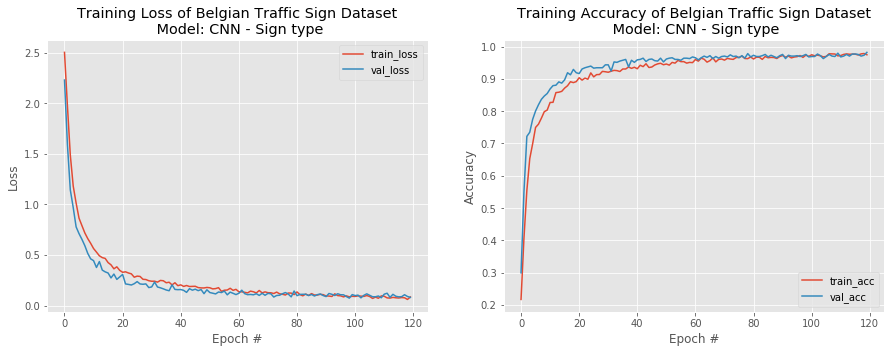

In [174]:
# batch_size = 64
epochs = 120

img_width, img_height = 28, 28

#build a model
model_cnn_sign = cnn_model_sign()

model_cnn_sign.load_weights('model_sign.h5')

#fit and evaluate the model
sign_model, sign_hist = fit_and_evaluate_model(model_cnn_sign, train_generator_sign, validation_generator_sign, 
                                    len(train_df_sign), len(validation_df_sign), batch_size, epochs, class_weights, 
                                               "CNN - Sign type")

We will now create test data generators and evaluate the accuracy of our model on test data

In [250]:
#augmentation for test data
test_datagen_sign = ImageDataGenerator(rescale=1. / 255)

#testing data generator
test_generator_sign = test_datagen_sign.flow_from_dataframe(
    dataframe=test_df_sign,
    directory='./',
    x_col="image_path",
    y_col="signLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 333 validated image filenames belonging to 16 classes.


In [251]:
# Evaluate the model on the test data using `evaluate_generator`
print('\nEvaluate on test data')
# results_shape = model_cnn.evaluate(x_test_shape, y_test_shape, batch_size=32)
results_sign = model_cnn_sign.evaluate_generator(test_generator_sign, len(test_df_sign))
print('test loss, test acc:', results_sign)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\nGenerate predictions for'+ str(len(test_df_sign))+'  samples')
predictions_sign = model_cnn_sign.predict(test_generator_sign)
print('predictions shape:', predictions_sign.shape)


Evaluate on test data
test loss, test acc: [0.055023433862846687, 0.978979, 0.97867066, 0.9801136, 0.97727275]

Generate predictions for333  samples
predictions shape: (333, 16)


In [255]:
print(classification_report(test_df_sign['signLabel_transformed'], np.argmax(predictions_sign, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00         8
           3       0.95      1.00      0.98        21
           4       1.00      1.00      1.00        11
           5       0.83      0.91      0.87        11
           6       1.00      1.00      1.00        34
           7       0.95      0.95      0.95        22
           8       1.00      1.00      1.00        25
           9       0.96      0.96      0.96        25
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        28
          12       0.75      0.75      0.75         4
          13       0.94      0.94      0.94        17
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        63

    accuracy                           0.98       333
   macro avg       0.96   

**As can be seen, it has higher accuracy and f1-score than SVC model & in general CNN is better than SVM for image classification especially when large data is there. So we will use CNN as our predicting model. Here, our dataset is not that large, so they have about same accuracy.**

## Independent Evaluation on Test Images

In [178]:
from PIL import Image

In [179]:
image_list_external = []

**Process all test data which are in different format to convert them to PNG file, resize it to 28 by 28 scale(as per our model input shape) and convert them from RGB to GrayScale.**

In [180]:
for filepath in glob.glob('trafficsigns_dataset_test/*/*/*.*', recursive=True):
    #change directory for saving processed data
    relative_path = filepath.replace("trafficsigns_dataset_test", "modified_data")
    
    #change file format
    converted_image_path = relative_path.replace('.ppm', '.png')
    
    #if new directory is not there, create it
    if not os.path.exists(os.path.dirname(converted_image_path)):
        os.makedirs(os.path.dirname(converted_image_path))
    else:
        if os.path.isfile(converted_image_path):
            os.remove(converted_image_path)
    
    #open test image
    image = Image.open(filepath)
    
    #process it to esize and convert to grascale
    image = image.resize((28, 28))
    image = image.convert('LA')
    
    #save to new path
    image.save(converted_image_path, format='png')
    
    shapeLabel_external = filepath.split("\\")[1]
    signLabel_external = filepath.split("\\")[2]
    
    #create list of paths, sign labels and shape labels
    image_list_external.append((converted_image_path, signLabel_external, shapeLabel_external))

In [181]:
print("Total Images: {0}".format( len(image_list_external)))

Total Images: 203


**this external test data is created by combining DITS(Italian traffic data), GTSRB(german traffic dataset) & original Belgium traffic test data(from web) and labeled manually**

In [182]:
# Create a data frame
data_external = pd.DataFrame(data=image_list_external, columns=['image_path', 'signLabel', 'shapeLabel'])

**Create external data generators & evaluate the accuracy of our Sign type classification model on this external test data**

In [257]:
#augmentation for test data
test_datagen_sign_external = ImageDataGenerator(rescale=1. / 255)

#testing data generator
test_generator_sign_external = test_datagen_sign_external.flow_from_dataframe(
    dataframe=data_external,
    directory='./',
    x_col="image_path",
    y_col="signLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 203 validated image filenames belonging to 16 classes.


In [258]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on external test data')
# results_sign = model_cnn.evaluate(x_test_sign, y_test_sign, batch_size=32)
results_sign_external = model_cnn_sign.evaluate_generator(test_generator_sign_external, len(data_external))
print('test loss, test acc:', results_sign_external)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for external samples')
predictions_sign_external = model_cnn_sign.predict(test_generator_sign_external)
print('predictions shape:', predictions_sign_external.shape)


# Evaluate on external test data
test loss, test acc: [0.5280693948401937, 0.87684727, 0.8810679, 0.88705146, 0.87540585]

# Generate predictions for external samples
predictions shape: (203, 16)


In [259]:
le_test = preprocessing.LabelEncoder()

print(classification_report(le_test.fit_transform(data_external['signLabel']), 
                            np.argmax(predictions_sign_external, axis=1)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         7
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           3       0.94      1.00      0.97        17
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         6
           6       0.54      1.00      0.70         7
           7       0.75      0.69      0.72        13
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        15
          10       1.00      0.71      0.83        14
          11       0.89      0.73      0.80        11
          12       1.00      0.75      0.86        16
          13       1.00      0.83      0.91         6
          14       0.90      0.53      0.67        17
          15       0.79      0.96      0.86        23

    accuracy                           0.88       203
   macro avg       0.89   

**Print random sample of External test images with it's correct value and predictions**

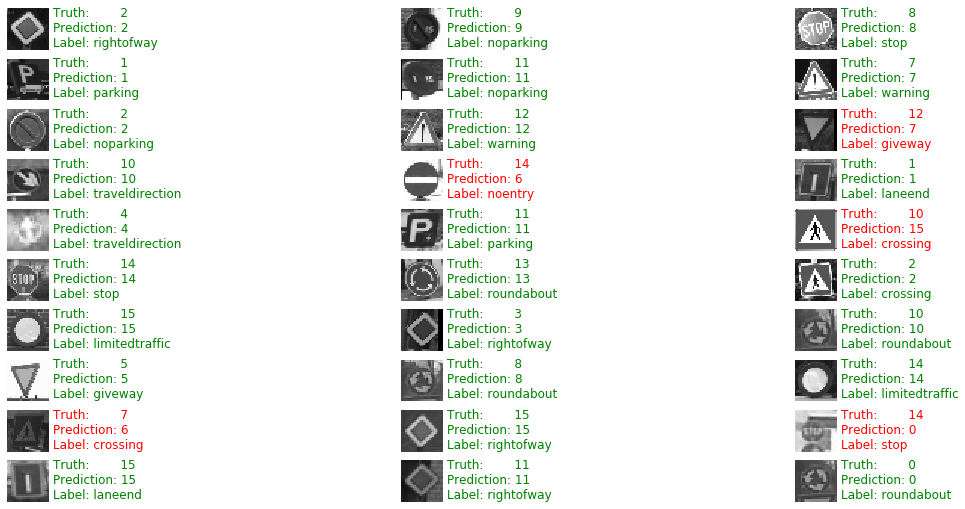

In [256]:
data_external1 = data_external.reset_index(drop = True)

sample_indexes = [i for i in random.sample(range(len(data_external1)), 30)]

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(20, 10))
for i, k in zip(sample_indexes,range(len(sample_indexes))):
    j = int(i/batch_size)
    l = int(i - j*batch_size)
    truth = np.argmax(test_generator_sign_external[j][1][l])
    prediction = np.argmax(predictions_sign_external[i])
    plt.subplot(int(len(sample_indexes)/3)+1, 3,1+k)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(30, 25, "Truth:        {0}\nPrediction: {1}\nLabel: {2}".format(truth, prediction, data_external1['signLabel'][i]), 
             fontsize=12, color=color)
    
    image = skimage.data.imread(data_external1['image_path'][i])
    plt.imshow(image,  cmap="gray")

plt.show()

**as can be seen, it works well on external data as well**

# Sign Shape Prediction

For the second task of Sign shape prediction, we will not train SVM model. Instead, we will go directly with CNN

## CNN on Sign Shape

In [186]:
np.unique(data['shapeLabel'])

array(['diamond', 'hex', 'round', 'square', 'triangle'], dtype=object)

In [187]:
le_shape = preprocessing.LabelEncoder()

In [188]:
data['shapeLabel_transformed'] = le_shape.fit_transform(data['shapeLabel'])

### Plot first image from each Shape type class

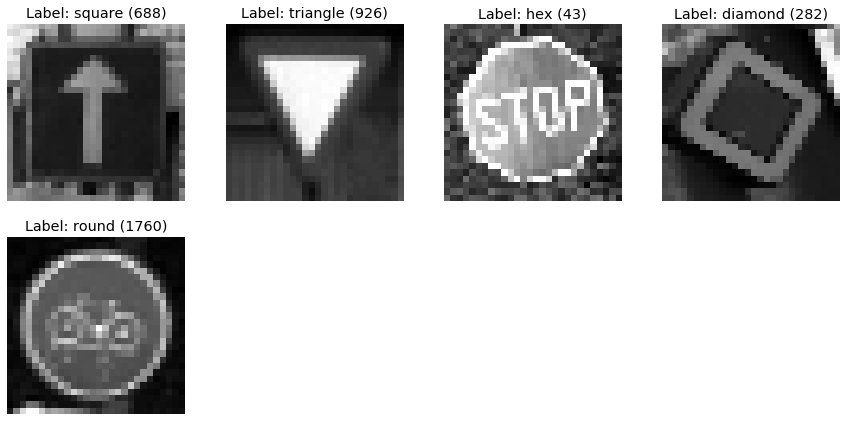

In [189]:
unique_labels_shape = set(data['shapeLabel'])

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels_shape:
    # You pick the first image for each label
    image = skimage.data.imread(data.loc[list(data['shapeLabel']).index(label)][0])
    # Define 16 subplots 
    plt.subplot(4, 4, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label: {0} ({1})".format(label, list(data['shapeLabel']).count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image, cmap="gray")
    
# Show the plot
plt.show()

**Plot bar chart of frequency count of each shape label in training data**

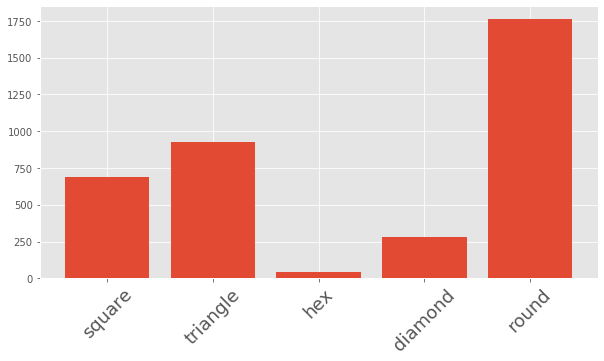

In [249]:
count = [list(data['shapeLabel']).count(label) for label in unique_labels_shape]
unique_labels_bar = [label for label in unique_labels_shape]

plt.figure(figsize=(10, 5))

plt.bar(np.arange(len(unique_labels_bar)), count)
plt.xticks(np.arange(len(unique_labels_bar)), unique_labels_bar, fontsize=18, rotation=45)

# Show the plot
plt.show()

**As can be seen, our target class labels are imblanced, so we can do augmentation/sampling to deal with this imbalance, but we will leverage the `class_weight` parameter of `fit_generator` to define imbalance. Aslo, only accuracy will not be a good measure for imbalanced class, so we will explore other metrics like precision, recall and f1-score.**

In [191]:
#split data into training and validation set
train_df_shape, validation_df_shape = train_test_split(data, test_size=0.3, 
                                                    stratify=data['shapeLabel'],random_state=42)

In [192]:
#split validation data into validation and test set
validation_df_shape, test_df_shape = train_test_split(validation_df_shape, test_size=0.3, 
                                                    stratify=validation_df_shape['shapeLabel'],random_state=42)

We will define dta generators to work on our model

In [193]:
#augmentation configuration used for training
train_datagen_shape = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=180,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    data_format='channels_last')

#augmentation configuration used for testing (only rescaling for validation and test data)
val_datagen_shape = ImageDataGenerator(rescale=1. / 255)


batch_size = 32

#training data generator
train_generator_shape = train_datagen_shape.flow_from_dataframe(
    dataframe=train_df_shape,
    directory='./',
    x_col="image_path",
    y_col="shapeLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


class_weights_shape = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator_shape.classes), 
            train_generator_shape.classes)


#validation data generator
validation_generator_shape = val_datagen_shape.flow_from_dataframe(
    dataframe=validation_df_shape,
    directory='./',
    x_col="image_path",
    y_col="shapeLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

Found 2589 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.


**Define test model to work on parameter tuning**

In [194]:
#set number of classes
num_classes_shape = len(unique_labels_shape)

In [219]:
#define CNN model_shape_test to be used for training our image classificatin data
def cnn_model_shape_test(dense_layer_sizes=[1024, 512], filters=16, kernel_size=(3,3), pool_size=(2,2), 
                         optimizer='rmsprop', init='uniform', activation='relu',learn_rate=0.0001):
        
    model_shape_test = Sequential()
    
    # Input layer
    model_shape_test.add(InputLayer(input_shape=(28, 28, 1)))
    #model_shape_test.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))
    
    #input_shape = (img_width, img_height, 3)
    #, input_shape=input_shape
    
    # Conv Layer 1
    model_shape_test.add(Conv2D(filters, kernel_size, kernel_initializer=init, padding='same'))
    model_shape_test.add(Activation(activation))
    # Conv Layer 2
    model_shape_test.add(Conv2D(filters, kernel_size, kernel_initializer=init))
    model_shape_test.add(Activation(activation))
    model_shape_test.add(MaxPooling2D(pool_size=pool_size))
    model_shape_test.add(Dropout(0.125))

    # Conv Layer 3
    model_shape_test.add(Conv2D(2*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_shape_test.add(Activation(activation))
    # Conv Layer 4
    model_shape_test.add(Conv2D(2*filters, kernel_size=kernel_size, kernel_initializer=init))
    model_shape_test.add(Activation(activation))
    model_shape_test.add(MaxPooling2D(pool_size=pool_size))
    model_shape_test.add(Dropout(0.125))

    # Conv Layer 5
    model_shape_test.add(Conv2D(4*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_shape_test.add(Activation(activation))
    # Conv Layer 6
    model_shape_test.add(Conv2D(4*filters, kernel_size=kernel_size, kernel_initializer=init, padding='same'))
    model_shape_test.add(Activation(activation))
    model_shape_test.add(MaxPooling2D(pool_size=pool_size))
    model_shape_test.add(Dropout(0.125))

    # MLP
    model_shape_test.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    for layer_size in dense_layer_sizes:
        model_shape_test.add(Dense(layer_size, kernel_initializer=init))
        model_shape_test.add(Activation(activation))
    model_shape_test.add(Dropout(0.4))
    model_shape_test.add(Dense(num_classes_shape))
    model_shape_test.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(lr=learn_rate, decay=1e-6)

    model_shape_test.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc',f1_m,precision_m, recall_m])
    
    # save the weights so that we can start from the same place when trying different configurations
    model_shape_test.save_weights('model_shape_test.h5')
    
    #model_shape_test.summary()
        
    return model_shape_test

In [213]:
Shape_labels1 = le.fit_transform(Shape_labels)
labels_training_shape = np.array(Shape_labels1)

labels_training_shape1 = keras.utils.to_categorical(labels_training_shape, num_classes_shape)


x_train_shape, x_test_shape, y_train_shape, y_test_shape = train_test_split(images_training, labels_training_shape1, 
                                                    test_size=0.2, stratify=labels_training_shape1,random_state=42)

# x_train_svm_shape, x_val_svm_shape, y_train_svm_shape, y_val_svm_shape = train_test_split(x_train_shape, y_train_shape, 
#                                                     test_size=0.2, stratify=y_train_shape,random_state=42)

In [214]:
y_train_shape.shape

(2959, 5)

In [215]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [216]:
# create model
model_shape_t = KerasClassifier(build_fn=cnn_model_shape_test, verbose=0, batch_size=32)

# Next parameter tuning chunks will take much time, be careful in executing.

**Grindsearch or RandomizedSearch through different combinations of hyper parameters. To reduce complexity, two different groups of parameters are tuned seperately instead of one go.**

In [217]:
# grid search filter, kernal size, pool size and density
filters = [16]
kernel_size = [3]
pool_size = [2]
# dense_size_candidates = [[512], [1024], [1024, 512]]
dense_size_candidates = [[1024, 512]]
epochs = [90, 120, 150]
learning_rate = [0.1, 0.0001]
activation = ['relu', 'tanh']



# filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
#     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
param_grid_shape = dict(filters=filters,kernel_size=kernel_size,pool_size=pool_size,
                        dense_layer_sizes=dense_size_candidates, learn_rate=learning_rate,activation=activation,
                        epochs=epochs)

grid_shape3 = RandomizedSearchCV(estimator=model_shape_t, param_distributions=param_grid_shape,
                         scoring='neg_log_loss',cv=2)

grid_result_shape3 = grid_shape3.fit(x_train_shape, y_train_shape)

# summarize results
print("Best: %f using %s" % (grid_result_shape3.best_score_, grid_result_shape3.best_params_))
means_shape = grid_result_shape3.cv_results_['mean_test_score']
stds_shape = grid_result_shape3.cv_results_['std_test_score']
params_shape = grid_result_shape3.cv_results_['params']
for mean, stdev, param in zip(means_shape, stds_shape, params_shape):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
best_model_shape = grid_result_shape3.best_estimator_.model
metric_names_shape = best_model_shape.metrics_names
metric_values_shape = best_model_shape.evaluate(x_test_shape, y_test_shape)
# for metric, value in zip(metric_names_shape, metric_values_shape):
#     print(metric, ': ', value)

Best: -0.105111 using {'pool_size': 2, 'learn_rate': 0.0001, 'kernel_size': 3, 'filters': 16, 'epochs': 150, 'dense_layer_sizes': [1024, 512], 'activation': 'relu'}
-18.103968 (0.204550) with: {'pool_size': 2, 'learn_rate': 0.1, 'kernel_size': 3, 'filters': 16, 'epochs': 150, 'dense_layer_sizes': [1024, 512], 'activation': 'relu'}
-22.072601 (3.762742) with: {'pool_size': 2, 'learn_rate': 0.1, 'kernel_size': 3, 'filters': 16, 'epochs': 90, 'dense_layer_sizes': [1024, 512], 'activation': 'relu'}
-0.123122 (0.008102) with: {'pool_size': 2, 'learn_rate': 0.0001, 'kernel_size': 3, 'filters': 16, 'epochs': 120, 'dense_layer_sizes': [1024, 512], 'activation': 'relu'}
-0.167404 (0.041040) with: {'pool_size': 2, 'learn_rate': 0.0001, 'kernel_size': 3, 'filters': 16, 'epochs': 150, 'dense_layer_sizes': [1024, 512], 'activation': 'tanh'}
-18.103968 (0.204550) with: {'pool_size': 2, 'learn_rate': 0.1, 'kernel_size': 3, 'filters': 16, 'epochs': 90, 'dense_layer_sizes': [1024, 512], 'activation': '

In [ ]:
# # grid search epochs and batches
# epochs = [90, 120, 150]
# batches = [32, 64, 128]

# # filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
# #     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
# param_grid_shape = dict(epochs=epochs, batch_size=batches)

# grid_shape = GridSearchCV(estimator=model_shape_t, param_grid=param_grid_shape,
#                          scoring='neg_log_loss')

# grid_result_shape = grid_shape.fit(x_train_shape, y_train_shape)

# # summarize results
# print("Best: %f using %s" % (grid_result_shape.best_score_, grid_result_shape.best_params_)) 
# means_shape = grid_result_shape.cv_results_['mean_test_score']
# stds_shape = grid_result_shape.cv_results_['std_test_score']
# params_shape = grid_result_shape.cv_results_['params']
# for mean, stdev, param in zip(means_shape, stds_shape, params_shape):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [220]:
# grid search optimizer, initialisation sizee and ctivation function
activation = ['relu', 'tanh']
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'uniform']
epochs = [150]

# filters=filters,kernel_size=kernel_size,pool_size=pool_size,optimizer=optimizers, epochs=epochs, batch_size=batches, 
#     init=init, dense_layer_sizes=dense_size_candidates,activation=activation
    
param_grid_shape4 = dict(optimizer=optimizers, init=init, epochs=epochs)

grid_shape4 = GridSearchCV(estimator=model_shape_t, param_grid=param_grid_shape4,
                         scoring='neg_log_loss',cv=2)

grid_result_shape4 = grid_shape4.fit(x_train_shape, y_train_shape)

In [221]:
# summarize results
print("Best: %f using %s" % (grid_result_shape4.best_score_, grid_result_shape4.best_params_))
means_shape = grid_result_shape4.cv_results_['mean_test_score']
stds_shape = grid_result_shape4.cv_results_['std_test_score']
params_shape = grid_result_shape4.cv_results_['params']
for mean, stdev, param in zip(means_shape, stds_shape, params_shape):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.110767 using {'epochs': 150, 'init': 'uniform', 'optimizer': 'adam'}
-0.125198 (0.034825) with: {'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
-0.142107 (0.036296) with: {'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-0.131660 (0.015715) with: {'epochs': 150, 'init': 'uniform', 'optimizer': 'rmsprop'}
-0.110767 (0.059032) with: {'epochs': 150, 'init': 'uniform', 'optimizer': 'adam'}


**The best parameter found from this tuning will be used to build our final model**

In [242]:
#define CNN model to be used for training our image classificatin data
def cnn_model_shape():
        
    model_shape = Sequential()
    
    # Input layer
    model_shape.add(InputLayer(input_shape=(28, 28, 3)))
    model_shape.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))
    
    # Conv Layer 1
    model_shape.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
    model_shape.add(Activation('relu'))
    model_shape.add(Conv2D(16, kernel_size=(3, 3)))
    model_shape.add(Activation('relu'))
    model_shape.add(MaxPooling2D(pool_size=(2, 2)))
    model_shape.add(Dropout(0.125))
    
    # Conv Layer 2
    model_shape.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model_shape.add(Activation('relu'))
    model_shape.add(Conv2D(32, kernel_size=(3, 3)))
    model_shape.add(Activation('relu'))
    model_shape.add(MaxPooling2D(pool_size=(2, 2)))
    model_shape.add(Dropout(0.125))

    # Conv Layer 3
    model_shape.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model_shape.add(Activation('relu'))
    model_shape.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model_shape.add(Activation('relu'))
    model_shape.add(MaxPooling2D(pool_size=(2, 2)))
    model_shape.add(Dropout(0.125))

    # MLP
    model_shape.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_shape.add(Dense(1024))
    model_shape.add(Activation('relu'))
    model_shape.add(Dense(512))
    model_shape.add(Activation('relu'))
    model_shape.add(Dropout(0.4))
    model_shape.add(Dense(num_classes_shape))
    model_shape.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    model_shape.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc',f1_m,precision_m, recall_m])
    
    # save the weights so that we can start from the same place when tring different configurations
    model_shape.save_weights('model_shape.h5')
    
    model_shape.summary()
    
    return model_shape

In [243]:
# batch_size = 16
epochs = 150

img_width, img_height = 28, 28

#build a model
model_cnn_shape = cnn_model_shape()

model_cnn_shape.load_weights('model_shape.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_814 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
activation_1205 (Activation) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_815 (Conv2D)          (None, 26, 26, 16)        2320      
_________________________________________________________________
activation_1206 (Activation) (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_402 (MaxPoolin (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_534 (Dropout)        (None, 13, 13, 16)        0         
__________

Epoch 1/150
81/81 [==============================] - 22s 272ms/step - loss: 1.3253 - acc: 0.4708 - f1_m: 0.1777 - precision_m: 0.4213 - recall_m: 0.1208 - val_loss: 1.2651 - val_acc: 0.4762 - val_f1_m: 0.2704 - val_precision_m: 0.4787 - val_recall_m: 0.1932
Epoch 2/150
81/81 [==============================] - 14s 171ms/step - loss: 1.2739 - acc: 0.4759 - f1_m: 0.2086 - precision_m: 0.4969 - recall_m: 0.1422 - val_loss: 1.2588 - val_acc: 0.4762 - val_f1_m: 0.3193 - val_precision_m: 0.4450 - val_recall_m: 0.2501
Epoch 3/150
81/81 [==============================] - 14s 167ms/step - loss: 1.2649 - acc: 0.4766 - f1_m: 0.2249 - precision_m: 0.5164 - recall_m: 0.1534 - val_loss: 1.2505 - val_acc: 0.4762 - val_f1_m: 0.0835 - val_precision_m: 0.5080 - val_recall_m: 0.0463
Epoch 4/150
81/81 [==============================] - 14s 168ms/step - loss: 1.2623 - acc: 0.4766 - f1_m: 0.2123 - precision_m: 0.5339 - recall_m: 0.1443 - val_loss: 1.2342 - val_acc: 0.4762 - val_f1_m: 0.1063 - val_precision_m

Epoch 21/150
81/81 [==============================] - 14s 178ms/step - loss: 0.8145 - acc: 0.6709 - f1_m: 0.6423 - precision_m: 0.7328 - recall_m: 0.5742 - val_loss: 0.7166 - val_acc: 0.7246 - val_f1_m: 0.7034 - val_precision_m: 0.7672 - val_recall_m: 0.6515
Epoch 22/150
81/81 [==============================] - 15s 179ms/step - loss: 0.7951 - acc: 0.6810 - f1_m: 0.6514 - precision_m: 0.7311 - recall_m: 0.5895 - val_loss: 0.6979 - val_acc: 0.7169 - val_f1_m: 0.6958 - val_precision_m: 0.7650 - val_recall_m: 0.6397
Epoch 23/150
81/81 [==============================] - 14s 178ms/step - loss: 0.7818 - acc: 0.6891 - f1_m: 0.6666 - precision_m: 0.7431 - recall_m: 0.6063 - val_loss: 0.6493 - val_acc: 0.7387 - val_f1_m: 0.7214 - val_precision_m: 0.7897 - val_recall_m: 0.6654
Epoch 24/150
81/81 [==============================] - 14s 170ms/step - loss: 0.7685 - acc: 0.6964 - f1_m: 0.6759 - precision_m: 0.7458 - recall_m: 0.6200 - val_loss: 0.6388 - val_acc: 0.7426 - val_f1_m: 0.7279 - val_precisi

Epoch 60/150
81/81 [==============================] - 13s 167ms/step - loss: 0.3879 - acc: 0.8590 - f1_m: 0.8590 - precision_m: 0.8762 - recall_m: 0.8429 - val_loss: 0.2163 - val_acc: 0.9228 - val_f1_m: 0.9215 - val_precision_m: 0.9312 - val_recall_m: 0.9124
Epoch 61/150
81/81 [==============================] - 13s 165ms/step - loss: 0.3826 - acc: 0.8598 - f1_m: 0.8583 - precision_m: 0.8736 - recall_m: 0.8440 - val_loss: 0.2209 - val_acc: 0.9176 - val_f1_m: 0.9163 - val_precision_m: 0.9264 - val_recall_m: 0.9068
Epoch 62/150
81/81 [==============================] - 14s 168ms/step - loss: 0.3686 - acc: 0.8733 - f1_m: 0.8699 - precision_m: 0.8853 - recall_m: 0.8555 - val_loss: 0.2509 - val_acc: 0.9060 - val_f1_m: 0.8945 - val_precision_m: 0.9134 - val_recall_m: 0.8772
Epoch 63/150
81/81 [==============================] - 14s 175ms/step - loss: 0.3837 - acc: 0.8598 - f1_m: 0.8629 - precision_m: 0.8819 - recall_m: 0.8453 - val_loss: 0.2015 - val_acc: 0.9305 - val_f1_m: 0.9299 - val_precisi

81/81 [==============================] - 13s 166ms/step - loss: 0.2393 - acc: 0.9181 - f1_m: 0.9169 - precision_m: 0.9271 - recall_m: 0.9072 - val_loss: 0.1357 - val_acc: 0.9537 - val_f1_m: 0.9521 - val_precision_m: 0.9564 - val_recall_m: 0.9481
Epoch 98/150
81/81 [==============================] - 13s 166ms/step - loss: 0.2215 - acc: 0.9193 - f1_m: 0.9201 - precision_m: 0.9282 - recall_m: 0.9123 - val_loss: 0.1370 - val_acc: 0.9472 - val_f1_m: 0.9446 - val_precision_m: 0.9489 - val_recall_m: 0.9406
Epoch 99/150
81/81 [==============================] - 13s 166ms/step - loss: 0.2433 - acc: 0.9081 - f1_m: 0.9102 - precision_m: 0.9214 - recall_m: 0.8997 - val_loss: 0.1417 - val_acc: 0.9472 - val_f1_m: 0.9503 - val_precision_m: 0.9552 - val_recall_m: 0.9456
Epoch 100/150
81/81 [==============================] - 13s 166ms/step - loss: 0.2374 - acc: 0.9154 - f1_m: 0.9163 - precision_m: 0.9258 - recall_m: 0.9073 - val_loss: 0.1340 - val_acc: 0.9537 - val_f1_m: 0.9522 - val_precision_m: 0.9553

81/81 [==============================] - 15s 183ms/step - loss: 0.1870 - acc: 0.9312 - f1_m: 0.9326 - precision_m: 0.9383 - recall_m: 0.9273 - val_loss: 0.1029 - val_acc: 0.9653 - val_f1_m: 0.9661 - val_precision_m: 0.9686 - val_recall_m: 0.9638
Epoch 137/150
81/81 [==============================] - 14s 172ms/step - loss: 0.1862 - acc: 0.9363 - f1_m: 0.9365 - precision_m: 0.9425 - recall_m: 0.9308 - val_loss: 0.0933 - val_acc: 0.9678 - val_f1_m: 0.9693 - val_precision_m: 0.9712 - val_recall_m: 0.9675
Epoch 138/150
81/81 [==============================] - 14s 171ms/step - loss: 0.1926 - acc: 0.9378 - f1_m: 0.9373 - precision_m: 0.9428 - recall_m: 0.9319 - val_loss: 0.1056 - val_acc: 0.9640 - val_f1_m: 0.9649 - val_precision_m: 0.9674 - val_recall_m: 0.9625
Epoch 139/150
81/81 [==============================] - 14s 167ms/step - loss: 0.1765 - acc: 0.9409 - f1_m: 0.9399 - precision_m: 0.9465 - recall_m: 0.9336 - val_loss: 0.0984 - val_acc: 0.9665 - val_f1_m: 0.9668 - val_precision_m: 0.96

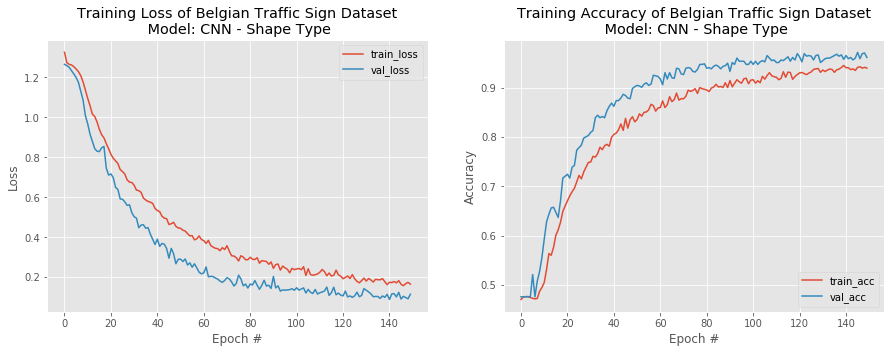

In [244]:
#fit and evaluate the model

shape_model, shape_hist = fit_and_evaluate_model(model_cnn_shape, train_generator_shape, validation_generator_shape, 
                                    len(train_df_shape), len(validation_df_shape), batch_size, epochs, 
                                                 class_weights_shape, "CNN - Shape Type")

In [260]:
for i in range(len(shape_model.layers)):
    layer = shape_model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d_814 (?, 28, 28, 16)
3 conv2d_815 (?, 26, 26, 16)
7 conv2d_816 (?, 13, 13, 32)
9 conv2d_817 (?, 11, 11, 32)
13 conv2d_818 (?, 5, 5, 64)
15 conv2d_819 (?, 5, 5, 64)


In [267]:
#augmentation for test data and evaluate the accuracy of our model on test data
test_datagen_shape = ImageDataGenerator(rescale=1. / 255)

#testing data generator
test_generator_shape = test_datagen_shape.flow_from_dataframe(
    dataframe=test_df_shape,
    directory='./',
    x_col="image_path",
    y_col="shapeLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 333 validated image filenames belonging to 5 classes.


In [268]:
# Evaluate the model on the test data using `evaluate`
print('\nEvaluate on test data')
# results_shape = model_cnn.evaluate(x_test_shape, y_test_shape, batch_size=32)
results_shape = model_cnn_shape.evaluate_generator(test_generator_shape, len(test_df_shape))
print('test loss, test acc:', results_shape)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\nGenerate predictions for'+ str(len(test_df_shape)) +' samples')
predictions_shape = model_cnn_shape.predict(test_generator_shape)
print('predictions shape:', predictions_shape.shape)


Evaluate on test data
test loss, test acc: [0.057835064489733086, 0.978979, 0.9759615, 0.9759615, 0.9759615]

Generate predictions for333 samples
predictions shape: (333, 5)


In [273]:
print(classification_report(test_df_shape['shapeLabel_transformed'], np.argmax(predictions_shape, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.67      1.00      0.80         4
           2       0.98      0.97      0.98       158
           3       0.97      0.98      0.98        62
           4       1.00      0.99      0.99        83

    accuracy                           0.98       333
   macro avg       0.92      0.98      0.95       333
weighted avg       0.98      0.98      0.98       333



## Independent Evaluation on Test Images

**Create external data generators & evaluate the accuracy of our Shape type classification model on this external test data**

**this external test data is created by combining DITS(Italian traffic data), GTSRB(german traffic dataset) & original Belgium traffic test data(from web) and labeled manually.**

In [275]:
#augmentation for test data
test_datagen_shape_external = ImageDataGenerator(rescale=1. / 255)

#testing data generator
test_generator_shape_external = test_datagen_shape_external.flow_from_dataframe(
    dataframe=data_external,
    directory='./',
    x_col="image_path",
    y_col="shapeLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 203 validated image filenames belonging to 5 classes.


In [276]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on external test data')
# results_shape_external = model_cnn.evaluate(x_test_shape_external, y_test_shape_external, batch_size=32)
results_shape_external = model_cnn_shape.evaluate_generator(test_generator_shape_external, 
                                                                     len(data_external))
print('test loss, test acc:', results_shape_external)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for external samples')
predictions_shape_external = model_cnn_shape.predict(test_generator_shape_external)
print('predictions shape:', predictions_shape_external.shape)


# Evaluate on external test data
test loss, test acc: [0.42325604228036745, 0.87684727, 0.86584777, 0.8842006, 0.84983766]

# Generate predictions for external samples
predictions shape: (203, 5)


**Print random sample of External test images with it's correct value and predictions**

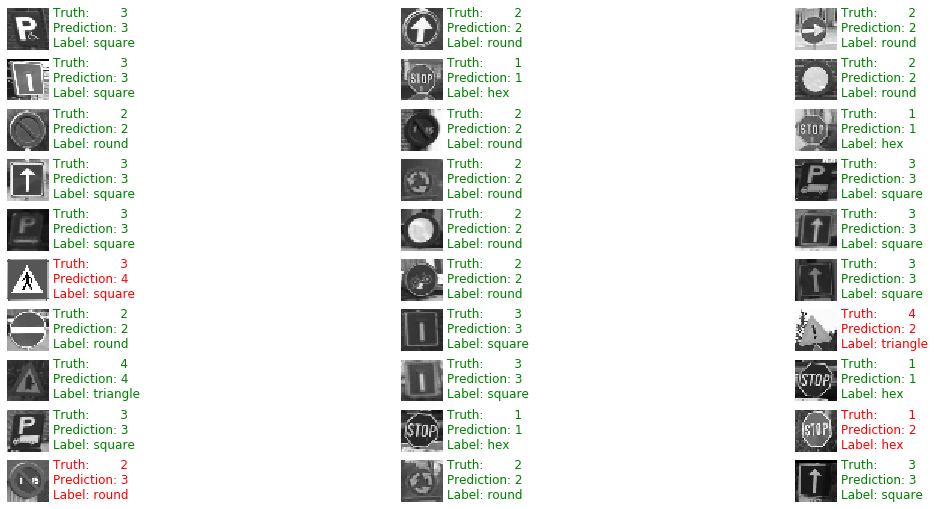

In [277]:
data_external1 = data_external.reset_index(drop = True)

sample_indexes = [i for i in random.sample(range(len(data_external1)), 30)]

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(20, 10))
for i, k in zip(sample_indexes,range(len(sample_indexes))):
    j = int(i/batch_size)
    l = int(i - j*batch_size)
    truth = np.argmax(test_generator_shape_external[j][1][l])
    prediction = np.argmax(predictions_shape_external[i])
    plt.subplot(int(len(sample_indexes)/3)+1, 3,1+k)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(30, 25, "Truth:        {0}\nPrediction: {1}\nLabel: {2}".format(truth, prediction, data_external1['shapeLabel'][i]), 
             fontsize=12, color=color)
    
    image = skimage.data.imread(data_external1['image_path'][i])
    plt.imshow(image,  cmap="gray")

plt.show()

**as can be seen, it works well on external data as well**

# Additional thing for Shape type only

As, different countries have diferent sign types, we can not evaluate sig type on others but we can evaluated shape data on other countries traffic sign just to compare.

**many of the the examples taken are of extreme case in detecting shape as per our model which can be seen in the graph below, but we are just comparing how well our model performs**

In [312]:
image_list_external_AU_IND = []

image_list_external_AU_IND_plot = []

In [313]:
for filepath in glob.glob('Austrlralian_Indian_Sign_Shape_test_data/*/*.*', recursive=True):
    
    image_list_external_AU_IND_plot.append(filepath)
    #change directory for saving processed data
    relative_path = filepath.replace("Austrlralian_Indian_Sign_Shape_test_data", "modified_Australia_India_data")
    
    #change file format
    converted_image_path1 = relative_path.replace('.jpg', '.png')
    converted_image_path = converted_image_path1.replace('.svg', '')
    
    #if new directory is not there, create it
    if not os.path.exists(os.path.dirname(converted_image_path)):
        os.makedirs(os.path.dirname(converted_image_path))
    else:
        if os.path.isfile(converted_image_path):
            os.remove(converted_image_path)
    
    #open test image
    image1 = Image.open(filepath)
    image = image1.copy()
    
    #Image.LANCZOS
    #image.thumbnail((28, 28), resample=3)
    
    #process it to resize and convert to grascale
    image = image.resize((28, 28))
    image = image.convert('LA')
    
    #save to new path
    image.save(converted_image_path, format='png')
    
    shapeLabel_external = filepath.split("\\")[1]
    
    #create list of paths, sign labels and shape labels
    image_list_external_AU_IND.append((converted_image_path, shapeLabel_external))

In [314]:
data_external_AU_IND = pd.DataFrame(data=image_list_external_AU_IND, columns=['image_path', 'shapeLabel'])

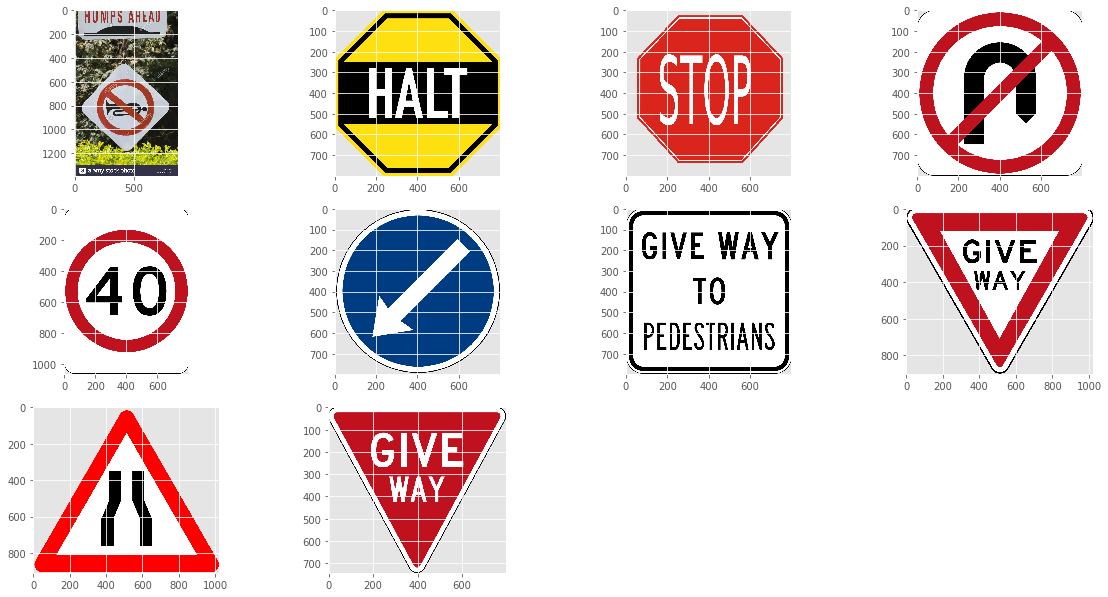

In [317]:
sample_indexes = np.arange(7,35, 3)

ig = plt.figure(figsize=(20, 14))

# Set a counter
j = 1

# For each unique label,
for i in sample_indexes:
    plt.subplot(4, 4, j)
    image = skimage.data.imread(image_list_external_AU_IND_plot[i])
    j += 1
    plt.imshow(image)
    
# Show the plot
plt.show()

In [309]:
#augmentation for test data
test_datagen_shape_external = ImageDataGenerator(rescale=1. / 255, featurewise_center=True, 
                                                 featurewise_std_normalization=True)

#testing data generator
test_generator_shape_external = test_datagen_shape_external.flow_from_dataframe(
    dataframe=data_external_AU_IND,
    directory='./',
    x_col="image_path",
    y_col="shapeLabel",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

Found 37 validated image filenames belonging to 5 classes.


In [310]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on external test data')
# results_shape_external = model_cnn.evaluate(x_test_shape_external, y_test_shape_external, batch_size=32)
results_shape_external = model_cnn_shape.evaluate_generator(test_generator_shape_external, 
                                                                     len(data_external_AU_IND))
print('test loss, test acc:', results_shape_external)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for external samples')
predictions_shape_external = model_cnn_shape.predict(test_generator_shape_external)
print('predictions shape:', predictions_shape_external.shape)


# Evaluate on external test data
test loss, test acc: [3.6531344652175903, 0.43243244, 0.5131147, 0.524138, 0.503125]

# Generate predictions for external samples
predictions shape: (37, 5)


In [311]:
# print total time taken
print("--- Total time taken: %s seconds ---" % (time.time() - start_time))

--- Total time taken: 83921.06353855133 seconds ---
